<a href="https://colab.research.google.com/github/Boonyaratt/Two-Tower-Recommendation/blob/master/Fix_Promotion_LGBMRanker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Import Library & Datasets

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from datetime import datetime, timedelta
from dateutil import easter
from typing import Dict, Text
import os, kagglehub
import lightgbm as lgb
import heapq
from functools import lru_cache
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
!mkdir Dataset

mkdir: cannot create directory ‘Dataset’: File exists


# Datasets

## 2.Display Dataset Information

In [ ]:
import os, pathlib
os.environ["KAGGLEHUB_CACHE"] = "/content/Dataset"  # exact case
pathlib.Path("/content/Dataset").mkdir(parents=True, exist_ok=True)

import kagglehub
kaggle_path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")
print(kaggle_path)

Using Colab cache for faster access to the 'dunnhumby-the-complete-journey' dataset.
/kaggle/input/dunnhumby-the-complete-journey


In [ ]:
# Read all CSV files

# path = "/kaggle/input/dunnhumby-the-complete-journey/"
path = "/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/"

campaign_desc = pd.read_csv(path + "campaign_desc.csv")
campaign_table = pd.read_csv(path + "campaign_table.csv")
coupon_redempt = pd.read_csv(path + "coupon_redempt.csv") ## 1 counpon_unc can have multiple product_id: 556 nunique from 2318
coupon = pd.read_csv(path + "coupon.csv")
product = pd.read_csv(path + "product.csv")
transaction_data = pd.read_csv(path + "transaction_data.csv")
# Check the dataframes
print("DataFrames loaded successfully!")
print(f"campaign_desc shape: {campaign_desc.shape}")
print(f"campaign_table shape: {campaign_table.shape}")
print(f"coupon_redempt shape: {coupon_redempt.shape}")
print(f"coupon shape: {coupon.shape}")
print(f"product shape: {product.shape}")
print(f"transaction_data shape: {transaction_data.shape}")

# Show headers for each dataset
print("Headers for each dataset:")
print("=" * 50)

datasets = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table,
    'coupon_redempt': coupon_redempt,
    'coupon': coupon,
    'product': product,
    'transaction_data': transaction_data
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Columns: {list(df.columns)}")



DataFrames loaded successfully!
campaign_desc shape: (30, 4)
campaign_table shape: (7208, 3)
coupon_redempt shape: (2318, 4)
coupon shape: (124548, 3)
product shape: (92353, 7)
transaction_data shape: (2595732, 12)
Headers for each dataset:

campaign_desc:
Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table:
Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

coupon_redempt:
Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']

coupon:
Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

product:
Columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']

transaction_data:
Columns: ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO', 'COUPON_DISC', 'COUPON_MATCH_DISC']


In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


###2-1. Sample Selection

####Houeholds Key Selection

In [ ]:
# keep top-N households by txn count (สำหรับเทสต์)
N_HH = 500
top_hh = (transaction_data["household_key"].value_counts().head(N_HH).index.astype(str))
transaction_data = transaction_data[transaction_data["household_key"].astype(str).isin(top_hh)].copy()
campaign_table   = campaign_table[campaign_table["household_key"].astype(str).isin(set(top_hh))].copy()
coupon_redempt   = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(set(top_hh))].copy()

#### Window day Selection

In [ ]:
# === OPTIONAL: Dataset windowing to speed up ===
# ใช้ช่วงวันล่าสุด N วัน (เช่น 180 วันล่าสุด) หรือกำหนดช่วงเองก็ได้
WINDOW_DAYS = 180

min_day_all = int(transaction_data["DAY"].min())
max_day_all = int(transaction_data["DAY"].max())
start_day = max(min_day_all, max_day_all - WINDOW_DAYS + 1)
end_day   = max_day_all

# 1) ตัดธุรกรรมให้เหลือเฉพาะช่วงวัน
transaction_data = transaction_data[(transaction_data["DAY"] >= start_day) & (transaction_data["DAY"] <= end_day)].copy()

# 2) จำกัด household ให้เหลือเฉพาะที่ยังมีธุรกรรมในช่วงวัน
keep_hh = set(transaction_data["household_key"].astype(str).unique())
campaign_table = campaign_table[campaign_table["household_key"].astype(str).isin(keep_hh)].copy()
coupon_redempt = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(keep_hh)].copy()

# 3) จำกัดแคมเปญให้ทับซ้อนช่วงวัน (START_DAY..END_DAY) กับหน้าต่างที่เลือก
campaign_desc = campaign_desc[
    (campaign_desc["END_DAY"] >= start_day) & (campaign_desc["START_DAY"] <= end_day)
].copy()
keep_campaigns = set(campaign_desc["CAMPAIGN"].astype(str).unique())
campaign_table = campaign_table[campaign_table["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()
coupon_redempt = coupon_redempt[coupon_redempt["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()
coupon = coupon[coupon["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()

# 4) (ออปชัน) จำกัดสินค้าให้เหลือเฉพาะที่ปรากฏในธุรกรรมช่วงนี้ เพื่อยุบมิติ OHE
keep_products = set(transaction_data["PRODUCT_ID"].astype(str).unique())
product = product[product["PRODUCT_ID"].astype(str).isin(keep_products)].copy()

print(f"Using DAY window [{start_day}, {end_day}]")
print("transaction_data:", transaction_data.shape, "campaign_desc:", campaign_desc.shape,
      "campaign_table:", campaign_table.shape, "coupon_redempt:", coupon_redempt.shape,
      "coupon:", coupon.shape, "product:", product.shape)

Using DAY window [532, 711]
transaction_data: (367796, 12) campaign_desc: (13, 4) campaign_table: (2168, 3) coupon_redempt: (1177, 4) coupon: (87484, 3) product: (36206, 7)


In [ ]:
transaction_data['household_key'] = transaction_data['household_key'].astype(str)
transaction_data['STORE_ID'] = transaction_data['STORE_ID'].astype(str)
transaction_data['PRODUCT_ID'] = transaction_data['PRODUCT_ID'].astype(str)
transaction_data['BASKET_ID'] = transaction_data['BASKET_ID'].astype(str)

# FIXED: Use .astype(str) instead of str() for the entire column
coupon['COUPON_UPC'] = coupon['COUPON_UPC'].astype(str)  # Changed this line
coupon['PRODUCT_ID'] = coupon['PRODUCT_ID'].astype(str)
coupon['CAMPAIGN'] = coupon['CAMPAIGN'].astype(str)

campaign_desc['CAMPAIGN'] = campaign_desc['CAMPAIGN'].astype(str)

coupon_redempt['household_key'] = coupon_redempt['household_key'].astype(str)
coupon_redempt['COUPON_UPC'] = coupon_redempt['COUPON_UPC'].astype(str)
coupon_redempt['CAMPAIGN'] = coupon_redempt['CAMPAIGN'].astype(str)

campaign_table['CAMPAIGN'] = campaign_table['CAMPAIGN'].astype(str)
campaign_table['household_key'] = campaign_table['household_key'].astype(str)

product['PRODUCT_ID'] = product['PRODUCT_ID'].astype(str)
product['DEPARTMENT'] = product['DEPARTMENT'].astype(str)
product['MANUFACTURER'] = product['MANUFACTURER'].astype(str)

##3.Data Preparation

###3-1. Merging

In [ ]:
# Define promotion key
coupon['COUPON_UPC'] = coupon['COUPON_UPC'].astype(str)
coupon['CAMPAIGN'] = coupon['CAMPAIGN'].astype(str)
campaign_desc['CAMPAIGN'] = campaign_desc['CAMPAIGN'].astype(str)
coupon_redempt['COUPON_UPC'] = coupon_redempt['COUPON_UPC'].astype(str)
coupon_redempt['CAMPAIGN'] = coupon_redempt['CAMPAIGN'].astype(str)

coupon['PROMO_KEY'] = coupon['COUPON_UPC'] + '|' + coupon['CAMPAIGN']
coupon_redempt['PROMO_KEY'] = coupon_redempt['COUPON_UPC'] + '|' + coupon_redempt['CAMPAIGN']

promo_catalog = coupon.merge(
    campaign_desc[['CAMPAIGN','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
)[['PROMO_KEY','COUPON_UPC','CAMPAIGN','PRODUCT_ID','START_DAY','END_DAY']]

# All campaigns per household
hh_campaigns = campaign_table[['household_key','CAMPAIGN']].drop_duplicates()
hh_promos = hh_campaigns.merge(
    promo_catalog[['CAMPAIGN','PROMO_KEY','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
).dropna(subset=['PROMO_KEY'])

# Promo -> set of products
promo_to_products = (
    coupon[['COUPON_UPC','CAMPAIGN','PRODUCT_ID']]
    .assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
    .groupby('PROMO_KEY')['PRODUCT_ID']
    .apply(lambda s: set(s.astype(str)))
    .to_dict()
)

# One-hot for promo metadata aggregated from product
coupon_prod = coupon.merge(
    product[['PRODUCT_ID','DEPARTMENT','BRAND']],
    on='PRODUCT_ID', how='left'
).assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
coupon_prod['DEPARTMENT'] = coupon_prod['DEPARTMENT'].fillna('UNK')
coupon_prod['BRAND'] = coupon_prod['BRAND'].fillna('UNK')
promo_ohe = pd.get_dummies(
    coupon_prod[['PROMO_KEY','DEPARTMENT','BRAND']], columns=['DEPARTMENT','BRAND'], drop_first=False
).groupby('PROMO_KEY').max().astype(bool)

# Promo popularity by redemptions
promo_pop = coupon_redempt['PROMO_KEY'].value_counts().to_dict()

# Redemptions per (household, DAY) as positives lookup
redempt_by_hh_day = (
    coupon_redempt.groupby(['household_key','DAY'])['PROMO_KEY']
    .apply(set).to_dict()
)

In [ ]:
coupon_redempt= coupon_redempt.merge(
    coupon[['COUPON_UPC', 'PRODUCT_ID']],
    on='COUPON_UPC',
    how='left'
)

coupon= coupon.merge(
    campaign_desc[['START_DAY', 'END_DAY', 'CAMPAIGN']],
    on='CAMPAIGN',
    how='left'
)

coupon = coupon.merge(
    product[['PRODUCT_ID', 'DEPARTMENT', 'MANUFACTURER']],
    on='PRODUCT_ID',
    how='left'
)


###3-2. Create Time *Features*

In [ ]:
# Create timestamp feature from DAY and TRANS_TIME
def create_timestamp(day, trans_time):
    base_date = datetime(2010, 3, 24)  # Arbitrary base date
    date_part = base_date + timedelta(days=int(day) - 1)

    # Convert TRANS_TIME to time
    hours = int(trans_time) // 100
    minutes = int(trans_time) % 100
    time_part = timedelta(hours=hours, minutes=minutes)

    return date_part + time_part

# Add timestamp to transaction_data
transaction_data['timestamp'] = transaction_data.apply(
    lambda row: create_timestamp(row['DAY'], row['TRANS_TIME']), axis=1
)

ts = transaction_data["timestamp"]
transaction_data["hour"]        = ts.dt.hour.astype("Int64")

transaction_data["dayofweek"]   = ts.dt.dayofweek.astype("Int64")    # 0=Mon .. 6=Sun
transaction_data["is_weekend"]  = transaction_data["dayofweek"].isin([5,6]).astype("int64")

transaction_data["day"]         = ts.dt.day.astype("Int64")
transaction_data["week"]        = ts.dt.isocalendar().week.astype("Int64")
transaction_data["month"]       = ts.dt.month.astype("Int64")
transaction_data["quarter"]     = ts.dt.quarter.astype("Int64")
transaction_data["year"]        = ts.dt.year.astype("Int64")

def make_part_of_day(hhmm_int):
    hh = hhmm_int // 100
    return (
        "night" if hh < 6 else
        "morning" if hh < 12 else
        "afternoon" if hh < 18 else
        "evening"
    )

transaction_data["part_of_day"] = transaction_data["TRANS_TIME"].astype(int).apply(make_part_of_day)
transaction_data = transaction_data.merge(
        product[['PRODUCT_ID', 'DEPARTMENT',"MANUFACTURER","BRAND"]],
        on='PRODUCT_ID',
        how='left'
    )

transaction_data = transaction_data.merge(
    coupon_redempt,
    on=['household_key', 'DAY', 'PRODUCT_ID'],
    how='left'
)


In [ ]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368093 entries, 0 to 368092
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   household_key      368093 non-null  object        
 1   BASKET_ID          368093 non-null  object        
 2   DAY                368093 non-null  int64         
 3   PRODUCT_ID         368093 non-null  object        
 4   QUANTITY           368093 non-null  int64         
 5   SALES_VALUE        368093 non-null  float64       
 6   STORE_ID           368093 non-null  object        
 7   RETAIL_DISC        368093 non-null  float64       
 8   TRANS_TIME         368093 non-null  int64         
 9   WEEK_NO            368093 non-null  int64         
 10  COUPON_DISC        368093 non-null  float64       
 11  COUPON_MATCH_DISC  368093 non-null  float64       
 12  timestamp          368093 non-null  datetime64[ns]
 13  hour               368093 non-null  Int64   

### 3-3. Global Constants

In [ ]:
RANDOM_STATE = 42
TOPK_CANDS = 100         # จำนวน candidates ต่อ query ที่จะป้อนเข้า ranker
EVAL_AT = [1,3,5,10]          # NDCG@5, NDCG@10

###3-4. Create *Sequential Orders* per household

Aggregate transactions into baskets per `(household_key, BASKET_ID)`:
- `items`: set of `PRODUCT_ID`s in basket.
- `basket_day`: the day of the basket.
- `next_items` / `next_day`: next basket’s items/day (for sequence context).

#### Why
Provides user history over time for candidate generation without leakage.

In [ ]:
transaction_data = transaction_data.sort_values(["household_key", "timestamp", "BASKET_ID"])
orders = (
    transaction_data.groupby(["household_key", "BASKET_ID"])
    .agg(items=("PRODUCT_ID", lambda s: set(s.tolist())),
         basket_day=("DAY", "min"))
    .reset_index()
)

# for now 'next_items' and 'next'day' is not neccesary for training due to we use real-time suggestion not next-day suggestion
orders["next_items"] = orders.groupby("household_key")["items"].shift(-1)
orders["next_day"] = orders.groupby("household_key")["basket_day"].shift(-1)
orders = orders.dropna(subset=["next_day"]).reset_index(drop=True)

In [ ]:
orders

,household_key,BASKET_ID,items,basket_day,next_items,next_day
0,1,35840912229,"{7130924, 5577022, 995242, 1124029, 1088462, 8...",535,{819312},536.0
1,1,35841522378,{819312},536,{9527290},537.0
2,1,35865806127,{9527290},537,{1069297},538.0
3,1,35877676640,{1069297},538,"{991580, 5569368, 5582712, 936685, 900875, 971...",540.0
4,1,36027807102,"{991580, 5569368, 5582712, 936685, 900875, 971...",540,"{5577022, 1069575, 856942, 961554}",546.0
...,...,...,...,...,...,...
32501,998,41918011754,"{1091365, 1134152, 1007136, 15830211}",683,"{981760, 995242, 849843, 899624, 845208}",691.0
32502,998,42031013564,"{981760, 995242, 849843, 899624, 845208}",691,{962568},693.0
32503,998,42049756099,{962568},693,"{843338, 865874, 12524086}",694.0
32504,998,42063285897,"{843338, 865874, 12524086}",694,"{1018085, 1049922, 6533765}",703.0


In [ ]:
transaction_data.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'timestamp', 'hour', 'dayofweek',
       'is_weekend', 'day', 'week', 'month', 'quarter', 'year', 'part_of_day',
       'DEPARTMENT', 'MANUFACTURER', 'BRAND', 'COUPON_UPC', 'CAMPAIGN',
       'PROMO_KEY'],
      dtype='object')

###3-5.Candidate Generation Baseline

## Candidate Generation Overview
We generate Top-K candidate promotions per query (household-day) using:
- Active promo filtering by household and day.
- Inverted index from `PRODUCT_ID → {PROMO_KEY}` to find promos overlapping user history.
- Scoring by overlap + tiny popularity prior:
  score(promo) = overlap(user_hist, promo_products) + 0.001 × global_popularity
- Force-in positives: same-day redeemed promos are injected to the candidate list and deduped.
- Fallback: fill remaining slots with active promos sorted by popularity.

Goal:
- High recall in retrieval so the ranker can reorder effectively at the final stage.

In [ ]:
# check if that id got the promotion on specific day
def get_active_promos_for_household_on_day(hh: str, day: int) -> list[str]:
    rows = hh_promos[hh_promos['household_key'] == hh]
    rows = rows[(rows['START_DAY'] <= int(day)) & (int(day) <= rows['END_DAY'])]
    return rows['PROMO_KEY'].tolist()

# create candidate list for hh-id in specific day
def build_promo_candidates(household_key: str, user_hist_items: set[str], day: int, topk: int = TOPK_CANDS) -> list[str]:
    active = get_active_promos_for_household_on_day(household_key, day) #check if it active for hh_id in that day
    if not active:
        return []
    # score by overlap with user history + 0.001 x global popularity
    def score(pkey: str) -> float:
        prods = promo_to_products.get(pkey, set())
        overlap = len(prods & set(user_hist_items or []))
        pop = promo_pop.get(pkey, 0)
        return overlap + 0.001 * pop
    ranked = sorted(active, key=score, reverse=True)
    return ranked[:topk]

###3-6. Build (query, candidate) labeled rows

#### Purpose
Efficiently create `pair_df` of (query, candidate promo, label) using:
- One query per household per day (`orders_day`).
- `hist_exclusive` (history before the day) to avoid leakage.
- Active promo filtering with LRU cache.
- Inverted index from `PRODUCT_ID -> {PROMO_KEY}` to propose promos overlapping user history.
- `heapq.nlargest` for Top-K by overlap + tiny popularity prior.
- Fallback: fill remaining slots with most popular active promos.
- Labels: same-day redemptions are forced into candidates and marked `label=1`.

#### Outputs
- `pair_df`: columns `household_key`, `BASKET_ID`, `PROMO_KEY`, `label`.

In [ ]:
# Expect runtime : ~2 mins
# 1 query per 1 household_id per day
orders_day = (
    orders.sort_values(["household_key","basket_day","BASKET_ID"])
    .groupby(["household_key","basket_day"], as_index=False)
    .first()  # use only first basket_id on that day
    .rename(columns={"basket_day":"day_t"})
)
# สร้าง hist_exclusive (ประวัติก่อนตะกร้าปัจจุบัน)
def _add_hist_exclusive_per_day(grp):
    hist = set()
    res = []
    for s in grp["items"]:
        res.append(hist.copy())
        hist |= s
    out = grp.copy()
    out["hist_exclusive"] = res
    return out

orders_fast = (
    orders_day.sort_values(["household_key","day_t"])
    .groupby("household_key", group_keys=False)
    .apply(_add_hist_exclusive_per_day)
    .reset_index(drop=True)
)

# 1) Pre-index promos per household (active filter เร็ว)
hh_to_promos = {
    hh: grp[["START_DAY","END_DAY","PROMO_KEY"]].to_numpy()
    for hh, grp in hh_promos.groupby("household_key", sort=False)
}

@lru_cache(maxsize=1_000_000)
def get_active_promos_tuple(hh: str, day: int) -> tuple:
    arr = hh_to_promos.get(hh)
    if arr is None:
        return ()
    d = int(day)
    mask = (arr[:,0] <= d) & (d <= arr[:,1])
    if not mask.any():
        return ()
    return tuple(arr[mask][:,2])

# 2) Inverted index: PRODUCT_ID -> set(PROMO_KEY)
product_to_promos = defaultdict(set)
for pkey, prods in promo_to_products.items():
    for pid in prods:
        product_to_promos[pid].add(pkey)

# 3) แคช active ที่เรียงตามความนิยมไว้เติม fallback
@lru_cache(maxsize=1_000_000)
def get_active_promos_sorted_by_pop(hh: str, day: int) -> tuple:
    active = get_active_promos_tuple(hh, day)
    if not active:
        return ()
    # เรียงตาม popularity จากมากไปน้อย
    return tuple(sorted(active, key=lambda k: promo_pop.get(k, 0), reverse=True))

# Locals
empty_set = frozenset()
promo_pop_local = promo_pop
promo_to_products_local = promo_to_products
redempt_by_hh_day_local = redempt_by_hh_day
TOPK = TOPK_CANDS  # ปรับลงเป็น 20 ชั่วคราวได้ตอนเทสต์

# 4) Build columns
rng = np.random.RandomState(42)
col_hh, col_bid, col_promo, col_label = [], [], [], []

for r in orders_fast.itertuples(index=False):
    hh = r.household_key
    bid = r.BASKET_ID
    day_t = int(r.day_t)
    user_hist = r.hist_exclusive if isinstance(r.hist_exclusive, set) else set(r.hist_exclusive)

    active = get_active_promos_tuple(hh, day_t)
    if not active:
        continue
    active_set = set(active)

    # 4.1) ใช้ inverted index สร้างชุด candidate จากสินค้าที่ user เคยซื้อ (ลดขนาดอย่างมาก)
    cand_from_hist = set()
    # จำกัดขนาดประวัติ (เช่น 200 ชิ้นล่าสุด) เพื่อลดเวลา
    if len(user_hist) > 200:
        # แปลงเป็น list แล้วหยิบต้นๆ พอเป็นตัวแทน (hist_exclusive เป็น set จึงไม่มีลำดับที่แท้)
        user_hist_iter = list(user_hist)[:200]
    else:
        user_hist_iter = user_hist

    for pid in user_hist_iter:
        cand_from_hist |= product_to_promos.get(pid, empty_set)

    # เฉพาะโปรโมชันที่ active จริงในวันนั้น
    cand_from_hist &= active_set

    # 4.2) ให้คะแนนเฉพาะชุดที่ overlap (เล็กลงมาก) แล้วคัด TopK
    def score(pkey: str) -> float:
        prods = promo_to_products_local.get(pkey, empty_set)
        return (len(prods & user_hist) if prods else 0.0) + 0.001 * promo_pop_local.get(pkey, 0)

    if cand_from_hist:
        ranked_overlap = heapq.nlargest(TOPK, cand_from_hist, key=score)
    else:
        ranked_overlap = []

    # 4.3) เติม fallback ด้วย active ที่นิยมสูง (ไม่ต้องคำนวณ score เพิ่ม)
    if len(ranked_overlap) < TOPK:
        need = TOPK - len(ranked_overlap)
        fallback = []
        seen = set(ranked_overlap)
        for p in get_active_promos_sorted_by_pop(hh, day_t):
            if p not in seen:
                seen.add(p)
                fallback.append(p)
                if len(fallback) >= need:
                    break
        cands_base = ranked_overlap + fallback
    else:
        cands_base = ranked_overlap

    # 4.4) ใส่ positives (same-day) ให้อยู่ต้นๆ แล้ว dedupe
    positives = redempt_by_hh_day_local.get((hh, day_t), empty_set)
    if positives:
        pos_list = list(positives)
        if pos_list:
            seen = set()
            cands = []
            for p in pos_list:
                if p not in seen:
                    seen.add(p); cands.append(p)
            for p in cands_base:
                if p not in seen:
                    seen.add(p); cands.append(p)
            cands = cands[:TOPK]
        else:
            cands = cands_base[:TOPK]
    else:
        cands = cands_base[:TOPK]

    if not cands:
        continue
    rng.shuffle(cands)
    is_pos = positives.__contains__
    col_hh.extend([hh] * len(cands))
    col_bid.extend([int(bid)] * len(cands))
    col_promo.extend(cands)
    col_label.extend([1 if is_pos(p) else 0 for p in cands])


pair_df = pd.DataFrame({
    "household_key": col_hh,
    "BASKET_ID": col_bid,
    "PROMO_KEY": col_promo,
    "label": col_label
})
pair_df.head(3)

,household_key,BASKET_ID,PROMO_KEY,label
0,1,35840912229,54800111033|13,0
1,1,35840912229,50000540082|13,0
2,1,35840912229,55703711082|13,0


#### Downsample negatives (class balancing for training)

#### Class Balancing via Negative Downsampling
To stabilize training:
- Keep all positives, sample at most `max_neg_per_pos` negatives per query.
- Optionally drop groups with no positives.

Outcome:
- Reduces imbalance and training time.
- Preserves the original validation distribution (no downsampling on valid).

In [ ]:
def downsample_negatives(df, max_neg_per_pos=30, drop_neg_only_groups=True):
    def _sub(g):
        pos = g[g.label == 1]
        neg = g[g.label == 0]
        if len(pos) == 0:
            # ตัดกลุ่มนี้ทิ้งจาก train
            return g.iloc[0:0] if drop_neg_only_groups else neg.sample(min(50, len(neg)), random_state=42)
        keep_neg = neg.sample(min(len(pos) * max_neg_per_pos, len(neg)), random_state=42)
        return pd.concat([pos, keep_neg], axis=0)
    return df.groupby(['household_key','BASKET_ID'], group_keys=False).apply(_sub).reset_index(drop=True)

pair_df = downsample_negatives(pair_df, max_neg_per_pos=30)

### 3-7.PRomotion Feature Engineering

#### Purpose
Construct features per (query, promo):
- `feat_promo_pop`: promo redemption popularity.
- `feat_user_affinity`: sum of user’s purchases over products covered by the promo.
- `promo_ohe` one-hot: aggregated `DEPARTMENT_*` and `BRAND_*`.

Create `X` (features), `y` (labels), and `qid` (group id per query).

#### Outputs
- Feature matrix `X`, labels `y`, and grouping keys `qid`.

## Feature Engineering (High-Level)
We compose features at the (query, promo) level, grouped as:
- Popularity (train-only)
- Recency (train-only)
- Affinity (train-only)
- Coverage
- Similarity (history overlap)
- Temporal
- Promo OHE (DEPARTMENT/BRAND)

Key rule:
- Any statistics must be computed using training data only, then applied to both train and validation rows.

In [ ]:
# ตรวจ dtype key ให้ merge/group ได้เสมอ
def normalize_keys(df, keys):
    for k in keys:
        df[k] = df[k].astype(str)
    return df

# สร้างฐาน (pair_df + บริบทจาก orders_fast)
def build_base(pair_df, orders_fast):
    normalize_keys(pair_df, ['household_key','BASKET_ID'])
    normalize_keys(orders_fast, ['household_key','BASKET_ID'])

    base = pair_df.merge(
        orders_fast[['household_key','BASKET_ID','day_t','hist_exclusive']],
        on=['household_key','BASKET_ID'], how='left'
    )
    # guard
    assert {'household_key','BASKET_ID','PROMO_KEY','label','day_t','hist_exclusive'}.issubset(base.columns)
    base = base.reset_index(drop=True).copy()
    base['qid'] = base['household_key'].astype(str) + '_' + base['BASKET_ID'].astype(str)
    base['label'] = base['label'].astype(int)
    base['day_t'] = pd.to_numeric(base['day_t'], errors='coerce')
    return base


def make_scored_frame(model, Xv, base, valid_mask):
    vf = base.loc[valid_mask, ['qid','label']].copy()
    vf['score'] = model.predict(Xv)
    # break ties to remove order bias from candidate construction
    vf['score'] = vf['score'] + np.random.RandomState(42).normal(0, 1e-6, size=len(vf))
    vf['rank'] = vf.groupby('qid')['score'].rank(ascending=False, method='first')
    return vf

def hitrate_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    return (top.groupby('qid')['label'].max()).mean()

def recall_precision_at_k(df, k=10):
    got = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    pos_per_q = df.groupby('qid')['label'].sum()
    hit_per_q = got.groupby('qid')['label'].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()
    precision = got.groupby('qid')['label'].mean().mean()
    return float(recall), float(precision)

def mrr_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    first_hit = top[top['label']==1].groupby('qid')['rank'].min()
    return (1.0/first_hit).fillna(0).mean()

def map_at_k(df, k=10):
    tops = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    ap = []
    for qid, sub in tops.groupby('qid'):
        if sub['label'].sum() == 0:
            continue
        sub = sub.sort_values('rank')
        cum_hits = sub['label'].cumsum()
        prec_i = cum_hits / np.arange(1, len(sub)+1)
        ap.append((prec_i * sub['label']).sum() / sub['label'].sum())
    return np.mean(ap) if ap else 0.0

### Time-based Split & Purge Gap (Leakage-Free)
We use a chronological split to avoid temporal leakage:
- Sort by `day_t`, pick a cutoff by `test_ratio`, and apply a purge gap (e.g., 7 days).
- Train uses days ≤ (cutoff − purge), Validation uses days ≥ cutoff.
- We also assert there is no day overlap between train and valid.

Why this matters:
- Ensures all features (popularity, recency, affinity) can be computed from training history only.
- Prevents “future info” from leaking into training.

Example:
- Train period: day 532–655
- Purge gap: 7 days
- Valid period: day 662–704

In [ ]:
def make_time_based_split(base, test_ratio=0.2, purge_days=7):

    # เรียงเพื่อหา cutoff day (แต่ไม่เปลี่ยน index)
    sorted_days = base['day_t'].sort_values().unique()

    # หา cutoff day
    cutoff_idx = int(len(sorted_days) * (1 - test_ratio))
    cutoff_day = sorted_days[cutoff_idx]

    # ใส่ purge gap
    train_end_day = cutoff_day - purge_days
    valid_start_day = cutoff_day

    # สร้าง masks โดยใช้ index เดิมของ base
    train_mask = base['day_t'] <= train_end_day
    valid_mask = base['day_t'] >= valid_start_day

    print("="*60)
    print("TIME-BASED SPLIT")
    print("="*60)
    print(f"Train period: day {base.loc[train_mask, 'day_t'].min():.0f} - {base.loc[train_mask, 'day_t'].max():.0f}")
    print(f"Purge gap:    {purge_days} days")
    print(f"Valid period: day {base.loc[valid_mask, 'day_t'].min():.0f} - {base.loc[valid_mask, 'day_t'].max():.0f}")
    print(f"\nTrain samples: {train_mask.sum():,} ({train_mask.mean():.1%})")
    print(f"Valid samples: {valid_mask.sum():,} ({valid_mask.mean():.1%})")

    # ตรวจสอบว่าไม่มี overlap
    train_days_set = set(base.loc[train_mask, 'day_t'].unique())
    valid_days_set = set(base.loc[valid_mask, 'day_t'].unique())
    overlap = train_days_set & valid_days_set
    assert len(overlap) == 0, f"ERROR: Found {len(overlap)} overlapping days!"
    print(f"\n✅ No temporal overlap")

    # ตรวจสอบ (qid, PROMO_KEY) duplicates
    train_pairs = set(base.loc[train_mask, ['qid','PROMO_KEY']].apply(tuple, axis=1))
    valid_pairs = set(base.loc[valid_mask, ['qid','PROMO_KEY']].apply(tuple, axis=1))
    dup_pairs = train_pairs & valid_pairs
    print(f"(qid, PROMO_KEY) duplicates: {len(dup_pairs)}")
    if len(dup_pairs) > 0:
        print(f"⚠️ WARNING: {len(dup_pairs)} duplicate pairs")

    # คำนวณ group sizes
    grp_tr = base.loc[train_mask].groupby('qid').size().tolist()
    grp_va = base.loc[valid_mask].groupby('qid').size().tolist()

    print(f"\nTrain groups (queries): {len(grp_tr)}")
    print(f"Valid groups (queries): {len(grp_va)}")

    return train_mask, valid_mask, grp_tr, grp_va



In [ ]:
feat_base = build_base(pair_df, orders_fast)

train_mask, valid_mask, grp_tr, grp_va = make_time_based_split(
    feat_base,
    test_ratio=0.2,
    purge_days=7
)

y_tr = feat_base.loc[train_mask, 'label'].values
y_va = feat_base.loc[valid_mask, 'label'].values

# ⚠️ CRITICAL: เก็บ max_train_day สำหรับ feature engineering
max_train_day = feat_base.loc[train_mask, 'day_t'].max()
print(f"\n⚠️ Max train day for feature engineering: {max_train_day:.0f}")
assertexpected_max_train_day = feat_base.loc[train_mask, 'day_t'].max()
print(f"✅ Verified: max_train_day = {max_train_day:.0f} (matches train period)")

TIME-BASED SPLIT
Train period: day 532 - 655
Purge gap:    7 days
Valid period: day 662 - 704

Train samples: 17,907 (90.8%)
Valid samples: 1,608 (8.1%)

✅ No temporal overlap
(qid, PROMO_KEY) duplicates: 0

Train groups (queries): 349
Valid groups (queries): 58

⚠️ Max train day for feature engineering: 655
✅ Verified: max_train_day = 655 (matches train period)


In [ ]:
# === Cutoff & Safety ===
max_train_day = feat_base.loc[train_mask, 'day_t'].max()

print("Train day range:", feat_base.loc[train_mask, 'day_t'].min(), "→", max_train_day)
print("Valid day range:", feat_base.loc[valid_mask, 'day_t'].min(),  "→", feat_base.loc[valid_mask, 'day_t'].max())


Train day range: 532 → 655
Valid day range: 662 → 704


In [ ]:
def train_and_eval_ranker(X_tr, y_tr, grp_tr, X_va, y_va, grp_va, base, valid_mask, eval_name=''):
    assert not pd.isnull(X_tr).any().any()
    assert not pd.isnull(X_va).any().any()

    ranker = lgb.LGBMRanker(
        objective='lambdarank', metric='ndcg',
        boosting_type='gbdt',
        num_leaves=127, learning_rate=0.05, n_estimators=1500,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
    callbacks = [lgb.log_evaluation(100), lgb.early_stopping(100, first_metric_only=True)]
    ranker.fit(
        X_tr, y_tr, group=grp_tr,
        eval_set=[(X_va, y_va)], eval_group=[grp_va],
        eval_at=[5,10], callbacks=callbacks
    )

    vf = make_scored_frame(ranker, X_va, base, valid_mask)
    results = {}
    for K in [1,3,5,10]:
        r,p = recall_precision_at_k(vf, K)
        results[f'Recall@{K}'] = r
        results[f'Precision@{K}'] = p
        results[f'HitRate@{K}'] = hitrate_at_k(vf, K)
        results[f'MRR@{K}'] = mrr_at_k(vf, K)
        results[f'MAP@{K}'] = map_at_k(vf, K)
    return ranker, results

In [ ]:
transaction_data.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'timestamp', 'hour', 'dayofweek',
       'is_weekend', 'day', 'week', 'month', 'quarter', 'year', 'part_of_day',
       'DEPARTMENT', 'MANUFACTURER', 'BRAND', 'COUPON_UPC', 'CAMPAIGN',
       'PROMO_KEY'],
      dtype='object')

In [ ]:
# ต้องมี coupon, product, transaction_data ในหน่วยความจำ
assert {'COUPON_UPC','CAMPAIGN','PRODUCT_ID'}.issubset(coupon.columns)
assert 'PRODUCT_ID' in product.columns

# PROMO_KEY
coupon = coupon.copy()
coupon['PROMO_KEY'] = coupon['COUPON_UPC'].astype(str) + '|' + coupon['CAMPAIGN'].astype(str)

# promo -> products
promo_to_products = (
    coupon[['PROMO_KEY','PRODUCT_ID']].drop_duplicates()
    .groupby('PROMO_KEY')['PRODUCT_ID'].apply(lambda s: set(s.dropna()))
    .to_dict()
)


promo_dept_set = (
    coupon_prod[['PROMO_KEY','DEPARTMENT']].drop_duplicates()
    .groupby('PROMO_KEY')['DEPARTMENT'].apply(lambda s: set(s.dropna()))
    .to_dict()
)

promo_brand_set = (
    coupon_prod[['PROMO_KEY','BRAND']].drop_duplicates()
    .groupby('PROMO_KEY')['BRAND'].apply(lambda s: set(s.dropna()))
    .to_dict()
)

### Recency Features (Train-Only)
Compute last purchase day for each `(household, PRODUCT_ID)` using only training transactions, then map to promo products:
- feat_min_recency = min(day_t − last_day)
- feat_mean_recency = mean(day_t − last_day)
- feat_seen_products = number of promo products seen in training history

This captures how recently the user interacted with products covered by the promo.

In [ ]:
def build_recency_features(base, max_train_day):

    print(f"[Recency] Using transactions up to day {max_train_day:.0f} (train period)")

    # ⚠️ กรอง transaction_data ให้เหลือเฉพาะก่อน validation period
    tx_train = transaction_data[transaction_data['DAY'] <= max_train_day].copy()

    last_day = (
        tx_train.groupby(['household_key','PRODUCT_ID'])['DAY']
        .max().rename('last_day').reset_index()
    )
    promo_prod_map = (
        coupon[['PROMO_KEY','PRODUCT_ID']].drop_duplicates()
    )

    tmp = (base[['household_key','PROMO_KEY','day_t']].drop_duplicates()
           .merge(promo_prod_map, on='PROMO_KEY', how='left')
           .merge(last_day, on=['household_key','PRODUCT_ID'], how='left'))
    tmp = tmp[tmp['last_day'].notnull()].copy()
    tmp = tmp[tmp['last_day'] <= tmp['day_t']]
    tmp['recency'] = pd.to_numeric(tmp['day_t'], errors='coerce') - pd.to_numeric(tmp['last_day'], errors='coerce')

    rec = tmp.groupby(['household_key','PROMO_KEY']).agg(
        feat_min_recency=('recency','min'),
        feat_mean_recency=('recency','mean'),
        feat_seen_products=('PRODUCT_ID','nunique')
    ).reset_index()

    out = base[['household_key','PROMO_KEY']].copy()
    out = out.merge(rec, on=['household_key','PROMO_KEY'], how='left')
    out[['feat_min_recency','feat_mean_recency']] = out[['feat_min_recency','feat_mean_recency']].fillna(9999)
    out['feat_seen_products'] = out['feat_seen_products'].fillna(0).astype(int)
    return out[['feat_min_recency','feat_mean_recency','feat_seen_products']].set_index(base.index)

print("✅ Fixed build_recency_features")

# ⚠️ เปลี่ยนจาก train_mask เป็น max_train_day
feat_recency = build_recency_features(feat_base, max_train_day)

✅ Fixed build_recency_features
[Recency] Using transactions up to day 655 (train period)


### Affinity Features (Train-Only)
Aggregate training transactions by `(household, DEPARTMENT)` and `(household, BRAND)`:
- feat_user_dept_aff: sum of user’s counts over promo’s departments
- feat_user_brand_aff: sum of user’s counts over promo’s brands

This measures the user’s affinity to the promo’s brand/department footprint.

In [ ]:
def build_user_affinity_features(base, max_train_day):
    """
    ⚠️ FIXED: คำนวณ user affinity จาก TRAIN data only เพื่อหลีกเลี่ยง temporal leakage
    รับ max_train_day โดยตรงแทน train_mask
    """
    print(f"[Affinity] Using transactions up to day {max_train_day:.0f} (train period)")

    # ⚠️ กรอง transaction_data ให้เหลือเฉพาะก่อน validation period
    tx = transaction_data[transaction_data['DAY'] <= max_train_day][['household_key','DEPARTMENT','BRAND']].copy()

    tx['household_key'] = tx['household_key'].astype(str)
    tx['DEPARTMENT'] = tx['DEPARTMENT'].fillna('UNK')
    tx['BRAND'] = tx['BRAND'].fillna('UNK')

    user_dept_ct = (
        tx.groupby(['household_key','DEPARTMENT']).size()
        .rename('user_dept_ct')
    )
    user_brand_ct = (
        tx.groupby(['household_key','BRAND']).size()
        .rename('user_brand_ct')
    )

    def sum_dept(row):
        depts = promo_dept_set.get(row['PROMO_KEY'], set())
        return int(sum(user_dept_ct.get((row['household_key'], d), 0) for d in depts))
    def sum_brand(row):
        brands = promo_brand_set.get(row['PROMO_KEY'], set())
        return int(sum(user_brand_ct.get((row['household_key'], b), 0) for b in brands))

    out = base[['household_key','PROMO_KEY']].copy()
    out['feat_user_dept_aff'] = out.apply(sum_dept, axis=1)
    out['feat_user_brand_aff'] = out.apply(sum_brand, axis=1)
    return out[['feat_user_dept_aff','feat_user_brand_aff']].set_index(base.index)

print("✅ Fixed build_user_affinity_features")

# ⚠️ เปลี่ยนจาก train_mask เป็น max_train_day
feat_affinity = build_user_affinity_features(feat_base, max_train_day)

✅ Fixed build_user_affinity_features
[Affinity] Using transactions up to day 655 (train period)


### Coverage Features
Static descriptors of the promo:
- feat_num_promo_products
- feat_num_promo_departments
- feat_num_promo_brands

These capture breadth/variety of items the promo covers.

In [ ]:
def build_coverage_features(base):
    out = base[['PROMO_KEY']].copy()
    out['feat_num_promo_products'] = out['PROMO_KEY'].map(lambda k: len(promo_to_products.get(k, set()))).astype(int)
    out['feat_num_promo_departments'] = out['PROMO_KEY'].map(lambda k: len(promo_dept_set.get(k, set()))).astype(int)
    out['feat_num_promo_brands'] = out['PROMO_KEY'].map(lambda k: len(promo_brand_set.get(k, set()))).astype(int)
    return out[['feat_num_promo_products','feat_num_promo_departments','feat_num_promo_brands']].set_index(base.index)

feat_coverage = build_coverage_features(feat_base)

In [ ]:
def build_promo_ohe_features(base):
    ohe = promo_ohe.copy()
    if ohe.index.name != 'PROMO_KEY':
        if 'PROMO_KEY' in ohe.columns:
            ohe = ohe.set_index('PROMO_KEY')
    out = ohe.reindex(base['PROMO_KEY']).fillna(0)
    for c in out.columns:
        if out[c].dtype == bool:
            out[c] = out[c].astype(np.uint8)
        elif out[c].dtype == object:
            out[c] = pd.to_numeric(out[c], errors='coerce').fillna(0).astype(np.uint8)
    out.index = base.index
    return out


### Popularity Features (Train-Only)
For each `PROMO_KEY` in train:
- promo_offer_ct: number of offers shown
- promo_pos_ct: number of redemptions
- promo_unique_users: unique households exposed
- feat_promo_pos_rate = promo_pos_ct / promo_offer_ct

Note: Values for unseen promos in validation are safely set to zeros (no leakage).

In [ ]:
# === Train-only popularity (global) ===
train_pairs = pair_df.loc[train_mask]  # IMPORTANT: อิง train_mask จาก time-split เท่านั้น
promo_stats_tr = (train_pairs.groupby('PROMO_KEY')['label']
                  .agg(offer_ct='count', pos_ct='sum')
                  .assign(pos_rate=lambda x: x['pos_ct'] / x['offer_ct'].clip(lower=1)))
feat_base = feat_base.join(promo_stats_tr, on='PROMO_KEY')
feat_base[['offer_ct','pos_ct','pos_rate']] = feat_base[['offer_ct','pos_ct','pos_rate']].fillna(0)


In [ ]:
def build_popularity_features(base, train_mask=None):
    """
    คำนวณ popularity features จาก TRAIN ONLY
    แล้ว apply ไปทั้ง train และ valid
    """
    # คำนวณจาก train เท่านั้น
    train_data = base.loc[train_mask]

    agg = train_data.groupby('PROMO_KEY').agg(
        promo_offer_ct=('label', 'size'),
        promo_pos_ct=('label', 'sum'),
        promo_unique_users=('household_key', 'nunique')
    )

    # Positive rate (redemption rate)
    agg['feat_promo_pos_rate'] = (agg['promo_pos_ct'] / agg['promo_offer_ct']).fillna(0.0)

    agg = agg[['promo_offer_ct', 'promo_pos_ct', 'promo_unique_users', 'feat_promo_pos_rate']].reset_index()

    # Join กลับไปทั้ง base (ทั้ง train และ valid)
    out = base[['PROMO_KEY']].merge(agg, on='PROMO_KEY', how='left')

    # Fill missing (promos ที่ไม่เคยปรากฏใน train)
    out = out.fillna({
        'promo_offer_ct': 0,
        'promo_pos_ct': 0,
        'promo_unique_users': 0,
        'feat_promo_pos_rate': 0.0
    })

    # เช็คว่า valid มี new promos เท่าไร
    valid_new_promos = (out.loc[~train_mask, 'promo_offer_ct'] == 0).sum()
    if valid_new_promos > 0:
        print(f"⚠️ WARNING: {valid_new_promos} validation samples have unseen promos (will use default values)")

    return out[['promo_offer_ct', 'promo_pos_ct', 'promo_unique_users', 'feat_promo_pos_rate']].set_index(base.index)


# ใช้งาน: แทนที่ Cell 56
# ⚠️ ต้อง build หลังจากมี train_mask จาก time-based split แล้ว
feat_popularity = build_popularity_features(feat_base, train_mask)


⚠️ WARNING: 738 validation samples have unseen promos (will use default values)


In [ ]:
# === Build cumulative history per (household_key, day_t) ===
def build_hist_until_day(transaction_data):
    tx = transaction_data.sort_values(['household_key','DAY','BASKET_ID'])
    out = []
    seen = {}  # hh -> set(PRODUCT_ID)
    for (hh, day), g in tx.groupby(['household_key','DAY'], sort=False):
        hist = seen.get(hh, set()).copy()  # อดีตล้วน ก่อน day_t
        out.append({'household_key': hh, 'day_t': int(day), 'hist_until_t': hist})
        items_today = set(g['PRODUCT_ID'].astype(str).unique())
        seen.setdefault(hh, set()).update(items_today)  # อัปเดตหลังบันทึก
    return (pd.DataFrame(out)
            .sort_values(['household_key','day_t'])
            .reset_index(drop=True))

hist_df = build_hist_until_day(transaction_data)
feat_base = feat_base.merge(hist_df, on=['household_key','day_t'], how='left')
feat_base['hist_until_t'] = feat_base['hist_until_t'].apply(lambda s: s if isinstance(s,set) else set())


### Similarity Features (History Overlap)
Using `hist_until_t` (history strictly before day_t):
- feat_hist_size = |history|
- feat_overlap_cnt = |promo_products ∩ history|
- feat_jaccard = |∩| / |∪|
- feat_overlap_ratio = |∩| / |history|

These measure how aligned the user’s past purchases are with the promo’s coverage.

In [ ]:
# === Similarity features (use hist_until_t) ===
import numpy as np
sim = pd.DataFrame(index=feat_base.index)

def promo_set(promo_key):
    return promo_to_products.get(promo_key, set())

hist_sizes = feat_base['hist_until_t'].apply(len)
overlaps   = (feat_base
              .apply(lambda r: len(promo_set(r['PROMO_KEY']) & r['hist_until_t']), axis=1))
union_sz   = (feat_base
              .apply(lambda r: len(promo_set(r['PROMO_KEY']) | r['hist_until_t']), axis=1))

sim['feat_hist_size']     = hist_sizes.astype('int32')
sim['feat_overlap_cnt']   = overlaps.astype('int16')
sim['feat_jaccard']       = (overlaps / union_sz.replace(0, np.nan)).fillna(0.0).astype('float32')
sim['feat_overlap_ratio'] = (overlaps / hist_sizes.replace(0, np.nan)).fillna(0.0).astype('float32')

feat_similarity = sim


### Temporal Features
- feat_dayofweek = day_t % 7
- feat_is_weekend = 1 if dayofweek ∈ {5,6} else 0

Temporal signals help capture weekly shopping patterns without using future info.

In [ ]:
def build_temporal_features(base):
    out = base[['day_t']].copy()
    day_t = pd.to_numeric(out['day_t'], errors='coerce').fillna(0).astype(int)
    out['feat_dayofweek'] = (day_t % 7).astype(np.int8)
    out['feat_is_weekend'] = out['feat_dayofweek'].isin([5,6]).astype(np.int8)
    return out[['feat_dayofweek','feat_is_weekend']].set_index(base.index)

feat_temporal = build_temporal_features(feat_base)

## From Feature Groups to Training Matrices
We evaluate each feature group individually and via forward selection:
- Train a ranker per group to measure standalone utility.
- Iteratively add the next-best group and re-train.
- Select the cumulative set that maximizes validation metrics (e.g., MRR@10, Recall@10).

Example (current run):
Selected groups = [popularity, recency, temporal, coverage, affinity, promo_ohe]
Total features = 41

In [ ]:
feat_promo_ohe = build_promo_ohe_features(feat_base)
print("✓ feat_promo_ohe")
feature_groups = {
    'similarity': feat_similarity,
    'recency':    feat_recency,
    'affinity':   feat_affinity,
    'coverage':   feat_coverage,
    'popularity': feat_popularity,
    'temporal':   feat_temporal,
    'promo_ohe':  feat_promo_ohe,
}
# sanity
for name, df in feature_groups.items():
    assert (df.index == feat_base.index).all(), f'Index mismatch in {name}'

✓ feat_promo_ohe


## Sanity Check: Random Label Test
Procedure:
- Shuffle training labels, train the ranker, then evaluate on real validation labels.
Expected:
- NDCG@10 ≈ 0.10–0.25 (near random)
Interpretation:
- Higher values suggest memorization or leakage. We mitigate order/tie bias by adding a tiny jitter to prediction scores before ranking.

In [ ]:
def sanity_check_random_labels(X_tr, y_tr, grp_tr, X_va, y_va, grp_va):
    """
    Train โมเดลด้วย random labels แล้ววัด NDCG บน valid (real labels)
    Expected: NDCG@10 ควร ~0.1-0.2 (baseline random)
    """
    print("="*60)
    print("SANITY CHECK: Random Label Test")
    print("="*60)

    # Shuffle labels
    np.random.seed(999)
    y_tr_random = np.random.permutation(y_tr)

    # Train
    ranker_random = lgb.LGBMRanker(
        objective='lambdarank', metric='ndcg',
        boosting_type='gbdt', num_leaves=31,
        learning_rate=0.05, n_estimators=100,
        subsample=0.8, random_state=42, verbose=-1
    )

    ranker_random.fit(
        X_tr, y_tr_random, group=grp_tr,
        eval_set=[(X_va, y_va)], eval_group=[grp_va],
        eval_at=[10],
        callbacks=[lgb.early_stopping(20, verbose=False)]
    )

    # Predict
    scores = ranker_random.predict(X_va)
    # break ties so group ordering doesn't boost NDCG spuriously
    scores = scores + np.random.RandomState(999).normal(0, 1e-6, size=len(scores))

    # คำนวณ NDCG@10 per group
    ndcg_scores = []
    start = 0
    for grp in grp_va:
        end = start + grp
        y_true = y_va[start:end]
        y_pred = scores[start:end]

        if y_true.sum() > 0:  # มี positive
            # ndcg_score ต้องการ shape (1, n)
            ndcg = ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1), k=10)
            ndcg_scores.append(ndcg)

        start = end

    avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0

    print(f"\nNDCG@10 with RANDOM labels: {avg_ndcg:.4f}")
    print(f"Expected (baseline):        0.10 - 0.25")

    if avg_ndcg < 0.30:
        print("✅ PASS: Random NDCG is low (no memorization)")
    else:
        print("❌ FAIL: Random NDCG is high (possible overfitting/leakage)")

    return avg_ndcg




## Sanity Check: Hold-out Day-of-Week
Procedure:
- Train after excluding one day-of-week (e.g., Saturday), evaluate only on that day.
Interpretation:
- If NDCG@10 remains reasonable (> 0.25), the model is not overfitting to day-of-week artifacts.

In [ ]:
def sanity_check_holdout_dow(feat_base, X_all, y_all, grp_all, dow_to_holdout=5):
    """
    Train โดยตัด day-of-week ใดวันหนึ่งออก แล้วทดสอบบนวันนั้นเท่านั้น

    Parameters:
    -----------
    dow_to_holdout : int
        วันที่จะ hold out (0=Mon, 5=Sat, 6=Sun)
    """
    print("="*60)
    print(f"SANITY CHECK: Hold-out Day {dow_to_holdout} (0=Mon, 5=Sat)")
    print("="*60)

    # สร้าง dow column ถ้ายังไม่มี
    if 'feat_dayofweek' not in feat_base.columns:
        feat_base['feat_dayofweek'] = feat_base['day_t'].astype(int) % 7

    # Split
    train_mask_no_dow = feat_base['feat_dayofweek'] != dow_to_holdout
    valid_mask_dow_only = feat_base['feat_dayofweek'] == dow_to_holdout

    print(f"\nTrain (without day {dow_to_holdout}): {train_mask_no_dow.sum():,} samples")
    print(f"Valid (only day {dow_to_holdout}):    {valid_mask_dow_only.sum():,} samples")

    if valid_mask_dow_only.sum() == 0:
        print("⚠️ SKIP: No samples on this day")
        return None

    # Subset
    X_tr_no_dow = X_all[train_mask_no_dow]
    y_tr_no_dow = y_all[train_mask_no_dow]
    grp_tr_no_dow = feat_base.loc[train_mask_no_dow].groupby('qid').size().tolist()

    X_va_dow = X_all[valid_mask_dow_only]
    y_va_dow = y_all[valid_mask_dow_only]
    grp_va_dow = feat_base.loc[valid_mask_dow_only].groupby('qid').size().tolist()

    # Train
    ranker_no_dow = lgb.LGBMRanker(
        objective='lambdarank', metric='ndcg',
        boosting_type='gbdt', num_leaves=63,
        learning_rate=0.05, n_estimators=300,
        subsample=0.8, random_state=42, verbose=-1
    )

    ranker_no_dow.fit(
        X_tr_no_dow, y_tr_no_dow, group=grp_tr_no_dow,
        eval_set=[(X_va_dow, y_va_dow)], eval_group=[grp_va_dow],
        eval_at=[10],
        callbacks=[lgb.early_stopping(30, verbose=False)]
    )

    # Evaluate
    scores = ranker_no_dow.predict(X_va_dow)

    ndcg_scores = []
    start = 0
    for grp in grp_va_dow:
        end = start + grp
        y_true = y_va_dow[start:end]
        y_pred = scores[start:end]

        if y_true.sum() > 0:
            ndcg = ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1), k=10)
            ndcg_scores.append(ndcg)

        start = end

    avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0

    print(f"\nNDCG@10 on held-out day {dow_to_holdout}: {avg_ndcg:.4f}")

    # เปรียบเทียบกับ baseline
    if avg_ndcg > 0.3:
        print("✅ GOOD: Model generalizes well without this day")
    elif avg_ndcg > 0.15:
        print("⚠️ WARNING: Model struggles without this day (moderate DOW dependency)")
    else:
        print("❌ FAIL: Model fails without this day (strong temporal leakage)")

    return avg_ndcg





In [ ]:
results_rows = []
for name, F in feature_groups.items():
    X_tr = F.loc[train_mask].copy()
    X_va = F.loc[valid_mask].copy()

    # แปลง categorical (ถ้าเจอ) ให้เป็นตัวเลข/one-hot (ในชุดนี้เป็นตัวเลขอยู่แล้ว)
    for c in X_tr.columns:
        if X_tr[c].dtype == 'bool':
            X_tr[c] = X_tr[c].astype(np.uint8)
            X_va[c] = X_va[c].astype(np.uint8)

    _, res = train_and_eval_ranker(
        X_tr, y_tr, grp_tr,
        X_va, y_va, grp_va,
        base=feat_base, valid_mask=valid_mask,
        eval_name=name
    )
    res_row = {'group': name}
    res_row.update(res)
    results_rows.append(res_row)

single_group_results = pd.DataFrame(results_rows).sort_values(['Recall@10','MRR@10'], ascending=False)
single_group_results

Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.367913	valid_0's ndcg@10: 0.454008
Early stopping, best iteration is:
[1]	valid_0's ndcg@5: 0.427176	valid_0's ndcg@10: 0.524928
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.460942	valid_0's ndcg@10: 0.491456
Early stopping, best iteration is:
[35]	valid_0's ndcg@5: 0.49174	valid_0's ndcg@10: 0.528104
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.639454	valid_0's ndcg@10: 0.669861
Early stopping, best iteration is:
[15]	valid_0's ndcg@5: 0.686196	valid_0's ndcg@10: 0.710461
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.197431	valid_0's ndcg@10: 0.305035
Early stopping, best iteration is:
[1]	valid_0's ndcg@5: 0.9033	valid_0's ndcg@10: 0.9033
Evaluated only: ndcg@5
Training until validation scores don't impr

,group,Recall@1,Precision@1,HitRate@1,MRR@1,MAP@1,Recall@3,Precision@3,HitRate@3,MRR@3,...,Recall@5,Precision@5,HitRate@5,MRR@5,MAP@5,Recall@10,Precision@10,HitRate@10,MRR@10,MAP@10
0,similarity,0.040230,0.068966,0.068966,0.068966,0.068966,0.237069,0.137931,0.344828,0.189655,...,0.340230,0.137931,0.465517,0.216379,0.219684,0.521470,0.118966,0.620690,0.236487,0.232677
1,recency,0.096264,0.155172,0.155172,0.155172,0.155172,0.283046,0.143678,0.379310,0.250000,...,0.387069,0.137931,0.517241,0.281034,0.275287,0.513095,0.105172,0.655172,0.297462,0.281192
6,promo_ohe,0.057471,0.068966,0.068966,0.068966,0.068966,0.169540,0.086207,0.224138,0.140805,...,0.259647,0.100000,0.344828,0.168391,0.170019,0.471018,0.103448,0.603448,0.203756,0.199740
2,affinity,0.063218,0.086207,0.086207,0.086207,0.086207,0.188793,0.103448,0.275862,0.172414,...,0.237233,0.100000,0.379310,0.193103,0.192241,0.442857,0.105172,0.568966,0.218740,0.209168
3,coverage,0.038793,0.051724,0.051724,0.051724,0.051724,0.150862,0.080460,0.206897,0.120690,...,0.224138,0.086207,0.293103,0.139655,0.134483,0.416420,0.098276,0.551724,0.171921,0.165274
5,temporal,0.038793,0.051724,0.051724,0.051724,0.051724,0.145115,0.074713,0.189655,0.114943,...,0.189655,0.079310,0.275862,0.135632,0.130460,0.350739,0.087931,0.465517,0.160790,0.153407
4,popularity,0.029762,0.068966,0.068966,0.068966,0.068966,0.147167,0.086207,0.206897,0.132184,...,0.205829,0.093103,0.293103,0.152874,0.145761,0.336741,0.089655,0.413793,0.170183,0.159785


In [ ]:
def display_comprehensive_stats(feat_base, train_mask, valid_mask):
    """
    แสดงสถิติครอบคลุมสำหรับรายงาน
    """
    print("="*60)
    print("COMPREHENSIVE STATISTICS")
    print("="*60)

    # 1. Group sizes
    print("\n[1] GROUP SIZE STATISTICS")
    grp_size_train = feat_base.loc[train_mask].groupby('qid').size()
    grp_size_valid = feat_base.loc[valid_mask].groupby('qid').size()

    print("\nTrain:")
    print(grp_size_train.describe())

    print("\nValid:")
    print(grp_size_valid.describe())

    # 2. Label distribution
    print("\n[2] LABEL DISTRIBUTION")
    train_pos = feat_base.loc[train_mask, 'label'].sum()
    train_total = train_mask.sum()
    valid_pos = feat_base.loc[valid_mask, 'label'].sum()
    valid_total = valid_mask.sum()

    print(f"Train: {train_pos:,} positives / {train_total:,} total ({train_pos/train_total:.2%})")
    print(f"Valid: {valid_pos:,} positives / {valid_total:,} total ({valid_pos/valid_total:.2%})")

    # 3. Groups without negatives
    train_all_pos = (feat_base.loc[train_mask].groupby('qid')['label'].sum() ==
                     feat_base.loc[train_mask].groupby('qid')['label'].count()).sum()
    valid_all_pos = (feat_base.loc[valid_mask].groupby('qid')['label'].sum() ==
                     feat_base.loc[valid_mask].groupby('qid')['label'].count()).sum()

    print(f"\nGroups without negatives:")
    print(f"Train: {train_all_pos} / {len(grp_size_train)} ({train_all_pos/len(grp_size_train):.2%})")
    print(f"Valid: {valid_all_pos} / {len(grp_size_valid)} ({valid_all_pos/len(grp_size_valid):.2%})")

    # 4. Positive rate by DOW
    if 'feat_dayofweek' in feat_base.columns:
        print("\n[3] POSITIVE RATE BY DAY-OF-WEEK")
        print("\nTrain:")
        print(feat_base.loc[train_mask].groupby('feat_dayofweek')['label'].mean().to_string())
        print("\nValid:")
        print(feat_base.loc[valid_mask].groupby('feat_dayofweek')['label'].mean().to_string())

    # 5. Temporal coverage
    print("\n[4] TEMPORAL COVERAGE")
    print(f"Train days: {feat_base.loc[train_mask, 'day_t'].min():.0f} - {feat_base.loc[train_mask, 'day_t'].max():.0f} "
          f"({feat_base.loc[train_mask, 'day_t'].nunique()} unique days)")
    print(f"Valid days: {feat_base.loc[valid_mask, 'day_t'].min():.0f} - {feat_base.loc[valid_mask, 'day_t'].max():.0f} "
          f"({feat_base.loc[valid_mask, 'day_t'].nunique()} unique days)")


# ใช้งาน
display_comprehensive_stats(feat_base, train_mask, valid_mask)



COMPREHENSIVE STATISTICS

[1] GROUP SIZE STATISTICS

Train:
count    349.000000
mean      51.309456
std       27.898656
min       11.000000
25%       31.000000
50%       31.000000
75%       62.000000
max      100.000000
dtype: float64

Valid:
count    58.000000
mean     27.724138
std      13.051575
min       2.000000
25%      17.000000
50%      31.000000
75%      34.000000
max      61.000000
dtype: float64

[2] LABEL DISTRIBUTION
Train: 714 positives / 17,907 total (3.99%)
Valid: 100 positives / 1,608 total (6.22%)

Groups without negatives:
Train: 0 / 349 (0.00%)
Valid: 0 / 58 (0.00%)

[4] TEMPORAL COVERAGE
Train days: 532 - 655 (100 unique days)
Valid days: 662 - 704 (26 unique days)


In [ ]:
order = single_group_results['group'].tolist()  # เรียงจาก MRR@10 ดีสุดก่อน
cum_results = []
X_tr_cum = None
X_va_cum = None

for i, g in enumerate(order, 1):
    F = feature_groups[g]
    if X_tr_cum is None:
        X_tr_cum = F.loc[train_mask].copy()
        X_va_cum = F.loc[valid_mask].copy()
    else:
        X_tr_cum = pd.concat([X_tr_cum, F.loc[train_mask].copy()], axis=1)
        X_va_cum = pd.concat([X_va_cum, F.loc[valid_mask].copy()], axis=1)

    # cast bool → uint8
    for c in X_tr_cum.columns:
        if X_tr_cum[c].dtype == 'bool':
            X_tr_cum[c] = X_tr_cum[c].astype(np.uint8)
            X_va_cum[c] = X_va_cum[c].astype(np.uint8)

    _, res = train_and_eval_ranker(
        X_tr_cum, y_tr, grp_tr,
        X_va_cum, y_va, grp_va,
        base=feat_base, valid_mask=valid_mask,
        eval_name=f'forward_{i}_{g}'
    )
    res_row = {'step': i, 'added_group': g}
    res_row.update(res)
    cum_results.append(res_row)

forward_selection_results = pd.DataFrame(cum_results).sort_values('step')
forward_selection_results

Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.367913	valid_0's ndcg@10: 0.454008
Early stopping, best iteration is:
[1]	valid_0's ndcg@5: 0.427176	valid_0's ndcg@10: 0.524928
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.319902	valid_0's ndcg@10: 0.42726
Early stopping, best iteration is:
[4]	valid_0's ndcg@5: 0.374393	valid_0's ndcg@10: 0.472979
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.280696	valid_0's ndcg@10: 0.392981
Early stopping, best iteration is:
[1]	valid_0's ndcg@5: 0.386184	valid_0's ndcg@10: 0.392615
Evaluated only: ndcg@5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.312431	valid_0's ndcg@10: 0.376368
Early stopping, best iteration is:
[24]	valid_0's ndcg@5: 0.376338	valid_0's ndcg@10: 0.456587
Evaluated only: ndcg@5
Training until validation scores don't i

,step,added_group,Recall@1,Precision@1,HitRate@1,MRR@1,MAP@1,Recall@3,Precision@3,HitRate@3,...,Recall@5,Precision@5,HitRate@5,MRR@5,MAP@5,Recall@10,Precision@10,HitRate@10,MRR@10,MAP@10
0,1,similarity,0.040230,0.068966,0.068966,0.068966,0.068966,0.237069,0.137931,0.344828,...,0.340230,0.137931,0.465517,0.216379,0.219684,0.521470,0.118966,0.620690,0.236487,0.232677
1,2,recency,0.029310,0.051724,0.051724,0.051724,0.051724,0.181773,0.109195,0.258621,...,0.348440,0.131034,0.482759,0.198563,0.196264,0.568596,0.124138,0.689655,0.226457,0.221914
2,3,promo_ohe,0.035920,0.086207,0.086207,0.086207,0.086207,0.160057,0.086207,0.224138,...,0.241954,0.093103,0.327586,0.173851,0.165230,0.327915,0.082759,0.465517,0.192474,0.180446
3,4,affinity,0.061782,0.103448,0.103448,0.103448,0.103448,0.230460,0.126437,0.327586,...,0.391544,0.144828,0.551724,0.252011,0.250431,0.549754,0.117241,0.672414,0.266065,0.250753
4,5,coverage,0.036946,0.068966,0.068966,0.068966,0.068966,0.260222,0.137931,0.362069,...,0.341256,0.127586,0.465517,0.216667,0.218534,0.602504,0.125862,0.724138,0.249459,0.233877
5,6,temporal,0.016831,0.051724,0.051724,0.051724,0.051724,0.186535,0.109195,0.258621,...,0.268432,0.106897,0.362069,0.168966,0.160920,0.383539,0.089655,0.465517,0.183210,0.165127
6,7,popularity,0.027463,0.068966,0.068966,0.068966,0.068966,0.142406,0.080460,0.206897,...,0.195156,0.082759,0.275862,0.153448,0.143966,0.333292,0.082759,0.413793,0.170854,0.158440


In [ ]:
best_step = forward_selection_results.sort_values(['Recall@10','MRR@10'], ascending=False).iloc[0]['step']
selected_groups = single_group_results['group'].tolist()[:int(best_step)]

# สร้าง X_final ตาม selected_groups
X_tr_final = pd.concat([feature_groups[g].loc[train_mask].copy() for g in selected_groups], axis=1)
X_va_final = pd.concat([feature_groups[g].loc[valid_mask].copy() for g in selected_groups], axis=1)


final_ranker, final_metrics = train_and_eval_ranker(
    X_tr_final, y_tr, grp_tr,
    X_va_final, y_va, grp_va,
    base=feat_base, valid_mask=valid_mask,
    eval_name='final_selected_groups'
)
print(final_metrics)

vf = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)
for K in [1,3,5,10]:
    r,p = recall_precision_at_k(vf, K)
    hr  = hitrate_at_k(vf, K)
    mrr = mrr_at_k(vf, K)
    mAP = map_at_k(vf, K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")


for c in X_tr_final.columns:
    if X_tr_final[c].dtype == 'bool':
        X_tr_final[c] = X_tr_final[c].astype(np.uint8)
        X_va_final[c] = X_va_final[c].astype(np.uint8)

print('Selected groups:', selected_groups)
X_tr_final.shape, X_va_final.shape

Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@5: 0.252073	valid_0's ndcg@10: 0.35832
Early stopping, best iteration is:
[6]	valid_0's ndcg@5: 0.313401	valid_0's ndcg@10: 0.395869
Evaluated only: ndcg@5
{'Recall@1': np.float64(0.03694581280788177), 'Precision@1': np.float64(0.06896551724137931), 'HitRate@1': np.float64(0.06896551724137931), 'MRR@1': 0.06896551724137931, 'MAP@1': 0.06896551724137931, 'Recall@3': np.float64(0.2602216748768473), 'Precision@3': np.float64(0.13793103448275862), 'HitRate@3': np.float64(0.3620689655172414), 'MRR@3': 0.1925287356321839, 'MAP@3': 0.1925287356321839, 'Recall@5': np.float64(0.341256157635468), 'Precision@5': np.float64(0.12758620689655173), 'HitRate@5': np.float64(0.46551724137931033), 'MRR@5': 0.21666666666666667, 'MAP@5': 0.21853448275862067, 'Recall@10': np.float64(0.602504105090312), 'Precision@10': np.float64(0.12586206896551722), 'HitRate@10': np.float64(0.7241379310344828), 'MRR@10': 0.24945949644225507,

((17907, 39), (1608, 39))

##4.Train LGBMRanker (LambdaRank)

#### Purpose
Train a gradient-boosted ranking model with LambdaRank objective and NDCG metric.

#### Notes
- Uses early stopping callbacks.
- Consider `n_jobs=-1` to use all CPU cores.
- Training groups provided via `grp_tr`/`grp_va`.

##5.Evaluation
#### Purpose
Compute Recall@K and Precision@K across queries by taking the top-K per `qid`.

#### Outputs
- Printed Recall@10/3/1 and Precision@10/3/1 for validation.

In [ ]:
# ==========================================
# SANITY CHECK 1: Random Label Test
# ==========================================

print("\n" + "="*70)
print("RUNNING SANITY CHECK: RANDOM LABEL TEST")
print("="*70)
print("Expected: NDCG@10 should be ~0.10-0.25 (random baseline)")
print("If higher than 0.30 = model is memorizing or has leakage\n")

from sklearn.metrics import ndcg_score

random_ndcg = sanity_check_random_labels(
    X_tr_final, y_tr, grp_tr,
    X_va_final, y_va, grp_va
)

if random_ndcg < 0.30:
    print(f"\n✅ PASS: Random NDCG = {random_ndcg:.4f} < 0.30")
else:
    print(f"\n❌ FAIL: Random NDCG = {random_ndcg:.4f} >= 0.30 (too high!)")


RUNNING SANITY CHECK: RANDOM LABEL TEST
Expected: NDCG@10 should be ~0.10-0.25 (random baseline)
If higher than 0.30 = model is memorizing or has leakage

SANITY CHECK: Random Label Test

NDCG@10 with RANDOM labels: 0.2327
Expected (baseline):        0.10 - 0.25
✅ PASS: Random NDCG is low (no memorization)

✅ PASS: Random NDCG = 0.2327 < 0.30


In [ ]:
# ==========================================
# SANITY CHECK 2: Hold-out Saturday Test
# ==========================================

print("\n" + "="*70)
print("RUNNING SANITY CHECK: HOLD-OUT SATURDAY TEST")
print("="*70)
print("Training WITHOUT Saturday, testing ON Saturday only")
print("Expected: NDCG@10 should be >0.25 if model doesn't overfit to DOW\n")

# Concat train + valid
X_all = pd.concat([X_tr_final, X_va_final], axis=0)
y_all = np.concatenate([y_tr, y_va])

# สร้าง feat_base_combined (เฉพาะแถว train + valid)
combined_mask = train_mask | valid_mask
feat_base_combined = feat_base.loc[combined_mask].copy()

# เพิ่ม feat_dayofweek ถ้ายังไม่มี
if 'feat_dayofweek' not in feat_base_combined.columns:
    feat_base_combined['feat_dayofweek'] = feat_base_combined['day_t'].astype(int) % 7

from sklearn.metrics import ndcg_score

holdout_ndcg = sanity_check_holdout_dow(
    feat_base_combined,  # ⚠️ ใช้ feat_base_combined แทน feat_base
    X_all, y_all, grp_tr + grp_va,
    dow_to_holdout=5  # Saturday
)

if holdout_ndcg > 0.30:
    print(f"\n✅ PASS: Holdout NDCG = {holdout_ndcg:.4f} > 0.30 (generalizes well)")
elif holdout_ndcg > 0.15:
    print(f"\n⚠️ WARNING: Holdout NDCG = {holdout_ndcg:.4f} (moderate DOW dependency)")
else:
    print(f"\n❌ FAIL: Holdout NDCG = {holdout_ndcg:.4f} <= 0.15 (strong temporal leakage!)")


RUNNING SANITY CHECK: HOLD-OUT SATURDAY TEST
Training WITHOUT Saturday, testing ON Saturday only
Expected: NDCG@10 should be >0.25 if model doesn't overfit to DOW

SANITY CHECK: Hold-out Day 5 (0=Mon, 5=Sat)

Train (without day 5): 15,870 samples
Valid (only day 5):    3,645 samples

NDCG@10 on held-out day 5: 0.1517
⚠️ WARNING: Model struggles without this day (moderate DOW dependency)

⚠️ WARNING: Holdout NDCG = 0.1517 (moderate DOW dependency)


In [ ]:
# สร้าง valid_frame จาก pipeline ใหม่
valid_frame = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)

# คำนวณ metrics
for K in [1,3,5,10]:
    r,p = recall_precision_at_k(valid_frame, K)
    hr  = hitrate_at_k(valid_frame, K)
    mrr = mrr_at_k(valid_frame, K)
    mAP = map_at_k(valid_frame, K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")

K=1  Recall=0.0369  Precision=0.0690  HitRate=0.0690  MRR=0.0690  MAP=0.0690
K=3  Recall=0.2602  Precision=0.1379  HitRate=0.3621  MRR=0.1925  MAP=0.1925
K=5  Recall=0.3413  Precision=0.1276  HitRate=0.4655  MRR=0.2167  MAP=0.2185
K=10  Recall=0.6025  Precision=0.1259  HitRate=0.7241  MRR=0.2495  MAP=0.2339


In [ ]:
# === Cell 10: simple Recall@K / Precision@K ===
def recall_precision_at_k(df, k=10):
    got = (df.sort_values(["qid","score"], ascending=[True, False])
             .groupby("qid").head(k))
    # recall@k = #positive ที่ดึงติด / #positive ทั้งหมดในกลุ่ม
    pos_per_q = df.groupby("qid")["label"].sum()
    hit_per_q = got.groupby("qid")["label"].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()  # เฉลี่ยเฉพาะกลุ่มที่มี positive
    precision = got.groupby("qid")["label"].mean().mean()       # เฉลี่ย precision ต่อ qid
    return recall, precision


In [ ]:
# Build valid_frame from the new pipeline
# Requires: final_ranker, X_va_final, feat_base, valid_mask, and the metric utils loaded
valid_frame = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)

# Now compute metrics
recall10, precision10 = recall_precision_at_k(valid_frame, k=10)
print(f"Recall@10={recall10:.4f}  Precision@10={precision10:.4f}")

recall3, precision3 = recall_precision_at_k(valid_frame, k=3)
print(f"Recall@3={recall3:.4f}  Precision@3={precision3:.4f}")

recall1, precision1 = recall_precision_at_k(valid_frame, k=1)
print(f"Recall@1={recall1:.4f}  Precision@1={precision1:.4f}")

Recall@10=0.6025  Precision@10=0.1259
Recall@3=0.2602  Precision@3=0.1379
Recall@1=0.0369  Precision@1=0.0690


In [ ]:
# ต้องมีตัวแปรเหล่านี้จาก pipeline ใหม่: final_ranker, X_va_final, feat_base, valid_mask
# และมี promo_dept_set, promo_brand_set สำหรับบรรยายโปร

valid_scored = feat_base.loc[valid_mask, ['household_key','BASKET_ID','PROMO_KEY','label','qid','day_t']].copy()
valid_scored['score'] = final_ranker.predict(X_va_final)
valid_scored['rank']  = valid_scored.groupby('qid')['score'].rank(ascending=False, method='first').astype(int)
valid_scored['is_redeemed'] = valid_scored['label'].astype(int)

# บรรยาย metadata ของโปร (optional)
def _fmt_set(s):
    ss = sorted(map(str, s)) if isinstance(s, set) else []
    return ', '.join(ss[:5])  # ตัดให้สั้นอ่านง่าย
valid_scored['promo_departments'] = valid_scored['PROMO_KEY'].map(lambda k: _fmt_set(promo_dept_set.get(k, set())))
valid_scored['promo_brands']      = valid_scored['PROMO_KEY'].map(lambda k: _fmt_set(promo_brand_set.get(k, set())))

# ดูตัวอย่าง 10 แถวแรก
valid_scored.head(10)

,household_key,BASKET_ID,PROMO_KEY,label,qid,day_t,score,rank,is_redeemed,promo_departments,promo_brands
454,113,41756171507,51111120078|20,1,113_41756171507,671,-0.171842,1,1,"DRUG GM, UNK","National, UNK"
455,113,41756171507,57940033055|20,0,113_41756171507,671,-0.488491,30,0,UNK,UNK
456,113,41756171507,50000540082|23,0,113_41756171507,671,-0.185319,5,0,"DRUG GM, UNK","National, UNK"
457,113,41756171507,51380040009|23,0,113_41756171507,671,-0.463565,24,0,"GROCERY, UNK","National, UNK"
458,113,41756171507,55420811176|23,0,113_41756171507,671,-0.463565,25,0,"GROCERY, UNK","National, UNK"
459,113,41756171507,54589353176|20,0,113_41756171507,671,-0.287710,12,0,"DRUG GM, UNK","National, UNK"
460,113,41756171507,51200000076|23,0,113_41756171507,671,-0.464245,26,0,"GROCERY, UNK","National, UNK"
461,113,41756171507,54589399277|20,0,113_41756171507,671,-0.455263,19,0,"GROCERY, UNK","National, UNK"
462,113,41756171507,54100027032|20,0,113_41756171507,671,-0.464245,27,0,"GROCERY, UNK","National, UNK"
463,113,41756171507,57027211076|23,0,113_41756171507,671,-0.455263,20,0,"GROCERY, UNK","National, UNK"


In [ ]:
print('Selected groups:', selected_groups)
print('Num features:', X_tr_final.shape[1])

# นับฟีเจอร์ต่อกลุ่ม
for g in selected_groups:
    print(g, feature_groups[g].shape[1])

# รายชื่อคอลัมน์ฟีเจอร์ที่ใช้เทรน
pd.Series(X_tr_final.columns, name='feature').to_frame().head(30)

Selected groups: ['similarity', 'recency', 'promo_ohe', 'affinity', 'coverage']
Num features: 39
similarity 4
recency 3
promo_ohe 27
affinity 2
coverage 3


,feature
0,feat_hist_size
1,feat_overlap_cnt
2,feat_jaccard
3,feat_overlap_ratio
4,feat_min_recency
5,feat_mean_recency
6,feat_seen_products
7,DEPARTMENT_CHEF SHOPPE
8,DEPARTMENT_COSMETICS
9,DEPARTMENT_COUP/STR & MFG


In [ ]:
# ใช้โมเดลสุดท้าย
booster = final_ranker.booster_

gain_imp  = pd.Series(booster.feature_importance(importance_type='gain'),  index=X_tr_final.columns, name='gain').sort_values(ascending=False)
split_imp = pd.Series(booster.feature_importance(importance_type='split'), index=X_tr_final.columns, name='split').sort_values(ascending=False)

display(gain_imp.head(30).to_frame())
display(split_imp.head(30).to_frame())

,gain
feat_min_recency,5092.913312
feat_mean_recency,967.517593
feat_jaccard,905.199698
feat_user_brand_aff,792.547103
feat_user_dept_aff,718.976941
feat_hist_size,696.642585
feat_num_promo_products,502.526472
feat_overlap_ratio,347.854832
feat_overlap_cnt,169.020878
feat_num_promo_departments,72.945799


,split
feat_user_dept_aff,151
feat_user_brand_aff,142
feat_hist_size,120
feat_num_promo_products,97
feat_jaccard,54
feat_mean_recency,43
feat_overlap_ratio,42
feat_min_recency,21
DEPARTMENT_DRUG GM,10
feat_seen_products,9


In [ ]:
import shap, numpy as np

# แปลง bool → uint8 เผื่อยังมีหลงเหลือ
Xv = X_va_final.copy()
for c in Xv.columns:
    if Xv[c].dtype == bool:
        Xv[c] = Xv[c].astype(np.uint8)

sub_idx = np.random.RandomState(42).choice(len(Xv), size=min(4000, len(Xv)), replace=False)
Xv_sub = Xv.iloc[sub_idx]

explainer = shap.TreeExplainer(final_ranker.booster_)
shap_values = explainer.shap_values(Xv_sub)

shap_imp = pd.Series(np.abs(shap_values).mean(0), index=Xv_sub.columns, name='shap_mean_abs').sort_values(ascending=False)
display(shap_imp.head(30).to_frame())



,shap_mean_abs
feat_min_recency,0.053954
feat_jaccard,0.039008
feat_hist_size,0.021064
feat_user_dept_aff,0.017405
feat_user_brand_aff,0.015444
feat_mean_recency,0.014724
feat_overlap_cnt,0.012118
feat_num_promo_products,0.011438
feat_overlap_ratio,0.010439
BRAND_Private,0.004714


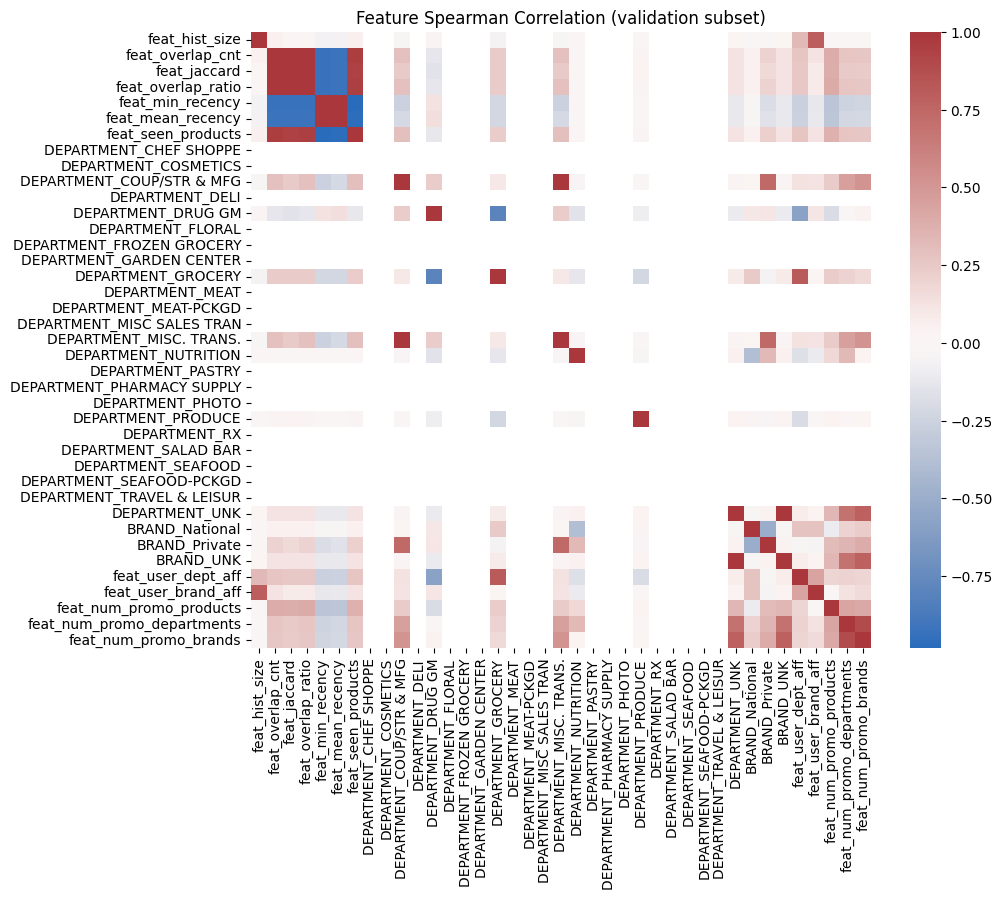

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

# ใช้เฉพาะ numeric และสุ่มลดขนาดเพื่อความเร็ว
Xv_num = X_va_final.select_dtypes(include=[np.number])
Xv_s = Xv_num.sample(n=min(8000, len(Xv_num)), random_state=42)

corr = Xv_s.corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr.clip(-1,1), cmap='vlag', center=0)
plt.title('Feature Spearman Correlation (validation subset)')
plt.show()

In [ ]:
def hitrate_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    return (top.groupby('qid')['label'].max()).mean()

def recall_precision_at_k(df, k=10):
    got = (df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k))
    pos_per_q = df.groupby('qid')['label'].sum()
    hit_per_q = got.groupby('qid')['label'].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()
    precision = got.groupby('qid')['label'].mean().mean()
    return recall, precision
def mrr_at_k(df, k=10):
    # คำนวณจากการจัดเรียง score ต่อ qid โดยตรง ไม่อาศัยคอลัมน์ rank
    def _mrr(g):
        labels = g.sort_values('score', ascending=False)['label'].to_numpy()[:k]
        for i, lab in enumerate(labels, start=1):
            if lab == 1:
                return 1.0 / i
        return 0.0
    return float(df.groupby('qid', group_keys=False).apply(_mrr).mean())

def map_at_k(df, k=10):
    # Average Precision@k ต่อ qid จากรายการที่เรียงตาม score
    def _ap(g):
        labels = g.sort_values('score', ascending=False)['label'].to_numpy()[:k]
        num_pos = labels.sum()
        if num_pos == 0:
            return 0.0
        cumsum = labels.cumsum()
        precisions = (cumsum / np.arange(1, len(labels) + 1)) * labels  # นับเฉพาะตำแหน่งที่เป็น hit
        # หารด้วย min(k, จำนวน positive ทั้งหมดในกลุ่ม)
        return float(precisions.sum() / min(num_pos, k))
    return float(df.groupby('qid', group_keys=False).apply(_ap).mean())
for K in [1,3,5,10]:
    r,p = recall_precision_at_k(valid_frame, k=K)
    hr  = hitrate_at_k(valid_frame, k=K)
    mrr = mrr_at_k(valid_frame, k=K)
    mAP = map_at_k(valid_frame, k=K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")

K=1  Recall=0.0369  Precision=0.0690  HitRate=0.0690  MRR=0.0690  MAP=0.0690
K=3  Recall=0.2602  Precision=0.1379  HitRate=0.3621  MRR=0.1925  MAP=0.1925
K=5  Recall=0.3413  Precision=0.1276  HitRate=0.4655  MRR=0.2167  MAP=0.2185
K=10  Recall=0.6025  Precision=0.1259  HitRate=0.7241  MRR=0.2495  MAP=0.2339


In [ ]:
from sklearn.metrics import ndcg_score

def ndcg_at_k_from_valid_frame(valid_frame, k=10):
    ndcgs = []
    for qid, g in valid_frame.groupby('qid'):
        y_true = g['label'].to_numpy()
        y_pred = g['score'].to_numpy()
        if y_true.sum() == 0:
            continue
        ndcgs.append(ndcg_score(y_true.reshape(1,-1), y_pred.reshape(1,-1), k=k))
    return float(np.mean(ndcgs)) if ndcgs else 0.0

print('NDCG@5 =', ndcg_at_k_from_valid_frame(valid_frame, k=5))
print('NDCG@10 =', ndcg_at_k_from_valid_frame(valid_frame, k=10))

NDCG@5 = 0.221509427766584
NDCG@10 = 0.3148434795615625
